Alan Lin  
Project Luther  
Topic: Lunch Price Prediction  

### Imported Libraries

In [1]:
import re
import json
import requests
import time
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
import statsmodels.api as sm
import itertools
import diagnostic_plots as dp_plot
#nltk.download('wordnet')

from bs4 import BeautifulSoup
from nltk.corpus import wordnet as wn
from scipy import special, stats
from collections import defaultdict
from copy import deepcopy
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import preprocessing, linear_model, tree, ensemble
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim

plt.rc('figure', figsize=(16.0, 10.0))
plt.style.use('fivethirtyeight')
% matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Class
Restaurant Class was defined as a way to store different attributes from the scraped data.

In [2]:
class Restaurant:
    
    def __init__(self, json):
        self.Name = json['name']
        self.Geo = json['geo']
        self.Types = json['servesCuisine']
        self.Menudf = create_menudf(json, json['name'])
        
    def get_coordinates(self):
        coords = (self.Geo['latitude'], self.Geo['longitude'])
        return coords

### Functions

In [3]:
# Scraping Functions
def gather_allmenus_links(restaurant_type):

    major_url = f'https://www.allmenus.com/ca/san-francisco/-/{restaurant_type.lower()}/'
    major_r = requests.get(major_url).text
    major_soup = BeautifulSoup(major_r, 'html5lib')
    major_parent = major_soup.find_all('section', class_ = 'restaurant-list-container s-col-md-8')[0]
    r_list = major_parent.find_all('li', class_  = 'restaurant-list-item clearfix')
    
    url_list = []
    for link in r_list:
        r_url = link.find('a')
        url_list.append(f'https://www.allmenus.com{r_url.get("href")}')
    
    return set(url_list)


def scrape_json(url):
    
    soup = BeautifulSoup(requests.get(url).text, 'html5lib')
    parent = soup.find_all('head')[0]
    children = parent.find_all("script")
    menu_child = children[1]
    json_html = re.sub(r'\r|\n', '', menu_child.text)
    return json.loads(json_html)

# Interpreting Data Functions
def get_dish_features(entry, name_list, desc_list, price_list):
    
    name_list.append(entry['name'])
    desc_list.append(entry['description'])
    # This is to catch entries missing price
    try:
        offers_list = entry['offers']
        first_offer = offers_list[0]
        price_list.append(first_offer['Price'])
    except:
        price_list.append(None)

def create_menudf(json, Res_Name):
    
    total_df = pd.DataFrame(columns = ['Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc', 'Dish Price'])
    
    try:
        menu_info = json['hasMenu'][0]
    except IndexError:
        print(f'No Menu for {Res_Name}')
        return None

    for MenuSections in menu_info['hasMenuSection']:

        # Holding name and description for each menu section
        MenuSectionName = MenuSections['name']
        MenuSectionDesc = MenuSections['description']

        # Lists that get_dish_features will be appending to
        ItemNames = []
        ItemDescs = []
        ItemPrices = []

        for Dish in MenuSections['hasMenuItem']:
            get_dish_features(Dish, ItemNames, ItemDescs, ItemPrices)

        section_df = pd.DataFrame({'Menu Section': MenuSectionName,
                                   'Menu Section Desc': MenuSectionDesc,
                                   'Dish Name': ItemNames,
                                   'Dish Desc': ItemDescs,
                                   'Dish Price': ItemPrices})

        total_df = total_df.append(section_df)

    total_df = total_df.reset_index(drop = True)
    return total_df

####################################################################################

# Packaging Functions
def create_rest_pkl(types_list, x, filename):
    
    """
    Function to create a pkl file from the allmenus links scraped using gather_allmenu_links.
    Function will parse json from the links and input into a Restaurant object before pickling it.
    
    Inputs
    types_list: List of restaurant types to search on all menus
    x: Sleep time
    Filename: Filename of output pickle file.
    """
    
    restaurant_list = []
    urls = []
    
    for rest_type in types_list:
        time.sleep(np.random.poisson(x))
        urls += gather_allmenus_links(rest_type)
    urls = set(urls)
    
    for i, link in enumerate(urls):
        if i % 10 == 0:
            print(i)
        time.sleep(np.random.poisson(x))
        try:
            restaurant_list.append(Restaurant(scrape_json(link)))
        except json.JSONDecodeError:
            print(f"Wasn't able to retrive JSON of: {link}")
        except KeyError:
            print(f"Had trouble processing dict of: {link}")
            
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(restaurant_list, picklefile)
        
def grab_nouns(txt):
    
    """
    Function that grabs the base nouns according the synset for the given piece of text
    """
    
    split_txt = re.split(r'[ &.]', txt)
    noun_list = []
    for i in split_txt:
        syn_list = wn.synsets(i)
        if len(syn_list) < 1 or len(i) < 3:
            pass
        elif syn_list[0].pos() == 'n':
            first_syn = syn_list[0]
            new_noun = first_syn.name().replace('_', '.').replace('-', '.')
            noun_list.append(new_noun.split('.')[0])
                
    return list(set(noun_list))     


def get_ingredients(alphabet_list, t, filename):
    
    """
    Scrapes the bbc.com/food and foodwise.com websites to create a base ingredient list. 
    Immediately then creates pickle file for set of ingredients.
    
    Inputs:
    alphabet_list: List of letters in alphabet
    t: Sleep time
    filename: Filename of output pkl file
    """
    
    all_ingredients = []
    
    for letter in alphabet_list:
        
        time.sleep(np.random.poisson(t))
        bbc_site = f'https://www.bbc.com/food/ingredients/by/letter/{letter}'
        ingr_soup = BeautifulSoup(requests.get(bbc_site).text, 'html5lib')
        try:
            parent = ingr_soup.find_all('ol', class_ = 'resources-by-letter')[0]
            for item in parent.find_all('li', class_ = 'resource food'):
                link = item.find('a')
                ingr = link.text.lower()
                ingr = re.search(r'\S+', ingr).group()
                ingr_noun = grab_nouns(ingr)
                [all_ingredients.append(i) for i in ingr_noun]

        except IndexError:
            print(f'No ingredients starting with {letter}')
    
    foodwise_url = 'http://www.foodwise.com.au/recipe-room/our-recipe-finder/'
    foodwise_soup = BeautifulSoup(requests.get(foodwise_url).text, 'html5lib')
    
    for i_ingred in foodwise_soup.find_all('li', class_ = 'ingred-link'):
        split_text = re.sub(r'[^a-zA-Z\s]', '', i_ingred.text).lower().split(' ')
        for item in split_text:
            nouns = grab_nouns(item)
            [all_ingredients.append(i) for i in nouns]
    
    all_ingredients = set(all_ingredients)
    
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(all_ingredients, picklefile)
        

def get_mock_price(x, pdict, Ndict):
    
    """
    Used to calculate the 'Mock Price' column in Xtrain and Xtest
    
    Inputs:
    x: list of nouns
    pdict: Reference price dictionary
    Ndict: Reference number dictionary
    """
    
    try:
        price_list = [pdict[i] / Ndict[i] for i in x]
    except ZeroDivisionError:
        return np.nan
    return np.sum(price_list)

####################################################################################

# DataFrame related helper functions

def create_allrestdf(restaurant_list, ingredients_list, zipcode_df, cat_status = False, drop_ingr = False, zip_demo = False):
    
    """
    Creates dataframe containing all of the restaurant data

    Inputs:
    restaurant_list: List of Restaurant objects
    ingredients_list: Set of base ingredients to compare to
    zipcode_df: Dataframe of zipcode information
    cat_status: Boolean to determine if categorical variables are added to the dataframe
    drop_ingr: Boolean to determine if ingredients should be dropped if they are under a certain number
    zip_demo: Boolean to determine if demographic data based on zipcode should be included
    """
    
    # Menu Section Words
    entree_words = ['supper', 'dinner', 'special', 'main', 'entree', 'brunch',
                    'meal', 'salad', 'burger', 'breakfast', 'sandwich', 'pizza',
                   'curry', 'pasta', 'omelet',]
    dessert_words = ['dessert']
    # only look at entrees and desserts
    section_words = set(entree_words + dessert_words)
    # Unallowed words are to remove keywords that signaled large format dishes
    unallowed_words = set(['platter', 'home', 'catering', 'tray'])
    
    # Collecting the top 20 most frequent restaurant types which were not in the excluded_types list
    all_types = [] 
    for i_rest in [i.Types for i in restaurant_list]:
        all_types += [i_type.replace(' &amp; ', '-').split( )[0].lower() for i_type in i_rest]

    zip_types = pd.Series(all_types).value_counts()
    excluded_types = ['bar', 'latin', 'middle']
    all_types = [i[1] for i in list(zip(zip_types,zip_types.index)) if (i[0] >= 20) & (i[1] not in excluded_types)]
    
    
    # Unpacking the information from the list of Restaurant objects and placing it in a Dataframe
    allrest_df = pd.DataFrame()
    for i_rest in restaurant_list:
        if type(i_rest.Menudf) != pd.DataFrame:
            pass
        else:
            df = i_rest.Menudf
            df['Restaurant Name'] = i_rest.Name
            df['Latitude'] = i_rest.get_coordinates()[0]
            df['Longitude'] = i_rest.get_coordinates()[1]
            df['Restaurant Types'] = [i_rest.Types] * len(df)
            allrest_df = allrest_df.append(df)

    # Filters
    allrest_df.fillna(value = np.nan, inplace = True)
    allrest_df.dropna(how = 'any', inplace = True)
    allrest_df = allrest_df[allrest_df['Dish Price'] != '']
    allrest_df[['Longitude', 'Latitude', 'Dish Price']] = allrest_df[['Longitude', 'Latitude', 'Dish Price']].applymap(float)
    # Delete any Dish less than $1
    allrest_df = allrest_df[allrest_df['Dish Price'] > 1]

    # Reordering
    allrest_df = allrest_df[['Dish Price', 'Restaurant Name', 'Restaurant Types', 'Longitude', 'Latitude',
                         'Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc']]

    # Creating Columns
    allrest_df['Total Dish Text'] = allrest_df['Dish Name'] + ' ' +  allrest_df['Dish Desc'].apply(lambda x: x.lower())
    allrest_df['Dish Text Length'] = allrest_df['Total Dish Text'].apply(len)
    allrest_df['Dish Nouns'] = allrest_df['Total Dish Text'].apply(grab_nouns)
    allrest_df['Section Nouns'] = allrest_df['Menu Section'].apply(grab_nouns).apply(tuple)
    
    
    # Make sure that dishes are entrees or desserts
    allrest_df['Allowable Section'] = allrest_df['Section Nouns'].apply(lambda x: True 
                                                                    if (len(section_words.intersection(set(x))) > 0) &
                                                                        (len(unallowed_words.intersection(set(x))) < 1)
                                                                    else False)
    allrest_df['Ingredients'] = allrest_df['Dish Nouns'].apply(lambda x: ingredients_list.intersection(set(x)))
    allrest_df['N_Ingredients'] = allrest_df['Ingredients'].apply(len)

    allrest_df['Restaurant Types'] = (allrest_df['Restaurant Types']
                                    .apply(lambda x: [i.replace(' &amp; ', '-').lower() for i in x])
                                    .apply(tuple))
    allrest_df['N_Types'] = allrest_df['Restaurant Types'].apply(len)
    
    
    # Numerical columns were a log was applied to them
    log_cols = ['Longitude', 'Latitude', 'Dish Text Length', 'N_Ingredients']
    for i in log_cols:
        allrest_df[f'log_{i}'] = allrest_df[i].apply(abs).apply(np.log10)
        
    # Adding categorical features
    if cat_status == True:
        
        # Restaurant type categorical features
        for i_type in all_types:
            allrest_df[f'{i_type}_Type'] = allrest_df['Restaurant Types'].apply(lambda x: 1 if f'{i_type}' in x else 0)
       
        # Ingredient type categorical features
        for i_ingr in ingredients_list:
            allrest_df[f'{i_ingr}_Type'] = allrest_df['Ingredients'].apply(lambda x: 1 if i_ingr in x else 0)
            
            if drop_ingr == True:
                
                # Drop ingredient column from Dataframe if there only ten or less rows that contain it
                if abs(allrest_df[f'{i_ingr}_Type'].sum()) < 11:
                    
                    allrest_df.drop(labels = f'{i_ingr}_Type', axis = 1, inplace = True)
                
    # Dropping rows that didn't reside in the dessert or entree menu sections
    allrest_df = allrest_df[allrest_df['Allowable Section'] == True].reset_index(drop = True)
    # Dropping row if there are no ingredients for that dish
    allrest_df = allrest_df[allrest_df['N_Ingredients'] != 0]
    
    # Including zipcode demographic information:
    if zip_demo == True:
        allrest_df = allrest_df.merge(zipcode_df, how = 'left', on = 'Restaurant Name')
        allrest_df.drop(columns = 'Zipcode', inplace = True)
        
    # Drop columns not used for calculation
    allrest_df = allrest_df.drop(labels = ['Menu Section Desc', 'Dish Name', 'Menu Section', 
                                       'Dish Desc', 'Total Dish Text', 'Restaurant Name', 'Restaurant Types',
                                       'Allowable Section', 'Dish Nouns'], axis = 1)

    
    return allrest_df


def ttsplit(base_df, dropcol_ls, power2_ls, lc_price, hc_price, N_ingr, L, drop_indexes = [], scaling_status = False):
    
    """
    Train test split function that creates additional columns and does scaling on numerical features
    
    Inputs:
    base_df: Dataframe that test train split will be applied on
    dropcol_ls: Columns that will be droppped from Dataframe
    power2_ls: Columns that degree 2 polynomial features will be created from
    lc_price: Number that for a given price under the dish is determined to be a low-price dish
    hc_price: Number that for a given price under the dish is determined to be a high-price dish
    N_ingr: Number of ingredients to determine the sets of high, mid, and low cost ingredients
    L: Lambda used to perform boxcox transformation on price data
    drop_indexes: Row entries from the dataframe to drop
    scaling_status: Boolean to determine if numerical features will be scaled
    """
    
    y_vals = base_df.iloc[:, 0]
    # Applying boxcox transformation to the price
    y_vals = y_vals.apply(lambda x: stats.boxcox(x, L))
    X_vals = base_df.iloc[:, 1:]

    Xtrain_df, Xtest_df, ytrain_df, ytest_df = train_test_split(X_vals, y_vals, test_size=0.3, random_state = 42)
    
    # Creating price Dataframe to determine what are high cost and low cost ingredients based on intersections
    price_df = pd.concat([ytrain_df, Xtrain_df[['Ingredients', 'N_Ingredients']]], axis = 1)
    
    lowcost_df = price_df[price_df['Dish Price'] < lc_price][['Dish Price', 'Ingredients']]
    lowcost_list = pd.Series(np.sum(lowcost_df['Ingredients'].apply(list).values))
    lc = set(lowcost_list.value_counts()[:N_ingr].index.values)

    midcost_df = price_df[(price_df['Dish Price'] >= lc_price) & (base_df['Dish Price'] < hc_price)][['Dish Price', 'Ingredients']]
    midcost_list = pd.Series(np.sum(midcost_df['Ingredients'].apply(list).values))
    mc = set(midcost_list.value_counts()[:N_ingr].index.values)

    highcost_df = price_df[(price_df['Dish Price'] >= hc_price)][['Dish Price', 'Ingredients']]
    highcost_list = pd.Series(np.sum(highcost_df['Ingredients'].apply(list).values))
    hc = set(highcost_list.value_counts()[:N_ingr].index.values)
    
    lc_only = lc - mc - hc
    
    # Creating price per ingredient column to calculate a mock price 
    price_df['N/P'] = np.round(price_df['Dish Price'] / price_df['N_Ingredients'], 2)
    zip_list = list(zip(price_df['Ingredients'], price_df['N/P']))
    tup_list = [[(i, j[1]) for i in j[0]] for j in zip_list]
    price_df['Tuples'] = tup_list
    price_list = np.sum(price_df['Tuples'].values)
    
    N_dict = defaultdict(int)
    price_dict = defaultdict(float)
    for entry in price_list:
        price_dict[entry[0]] += entry[1]
        N_dict[entry[0]] += 1

    # Ingredient cost related columns that are appended to the X_train and y_train    
    for i_df in [Xtrain_df, Xtest_df]:
        i_df['LC_Ingredients'] = i_df['Ingredients'].apply(lambda x: len(lc.intersection(x)))
        i_df['LC_Only'] = i_df['Ingredients'].apply(lambda x: len(lc_only.intersection(x)))   
        i_df['Mock_Price'] = i_df['Ingredients'].apply(lambda x: get_mock_price(x, price_dict, N_dict))
     
    # Creating quadratic polynomial features for columns listed in power2_ls
    for elem in power2_ls:
        Xtrain_df[f'{elem[0]} x {elem[1]}'] = Xtrain_df[elem[0]] * Xtrain_df[elem[1]]
        Xtest_df[f'{elem[0]} x {elem[1]}'] = Xtest_df[elem[0]] * Xtest_df[elem[1]]
    
    # Dropping rows that are specified in drop_indexes
    if len(drop_indexes) > 0:
        Xtrain_df.drop(index = drop_indexes, inplace = True)
        ytrain_df.drop(index = drop_indexes, inplace = True)
    
    Xtrain_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
    Xtest_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
    Xtest_df = Xtest_df.fillna(0)
    
    # Scaling the numeric features in the Xtrain and Xtest dfs. Requires removing categorical features,
    # performing scaling, and then reappending categorical features
    if scaling_status == True:
        
        noncat_cols = [i for i in Xtrain_df.columns if i[-5:] != '_Type']
        cat_cols = [i for i in Xtrain_df.columns if i[-5:] == '_Type']
        
        Xtrain_numeric = Xtrain_df[noncat_cols].reset_index(drop = True)
        Xtrain_nonnumeric = Xtrain_df[cat_cols].reset_index(drop = True)
        
        Xtest_numeric = Xtest_df[noncat_cols].reset_index(drop = True)
        Xtest_nonnumeric = Xtest_df[cat_cols].reset_index(drop = True)
        
        ssX = StandardScaler()
        ssX.fit(Xtrain_numeric)
        
        Xtrain_s = pd.DataFrame(ssX.transform(Xtrain_numeric), columns = noncat_cols)
        Xtest_s = pd.DataFrame(ssX.transform(Xtest_numeric), columns = noncat_cols)
        Xtrain_scaled = pd.concat([Xtrain_s, Xtrain_nonnumeric], axis = 1)
        Xtest_scaled = pd.concat([Xtest_s, Xtest_nonnumeric], axis = 1)
        return (Xtrain_scaled, Xtest_scaled, ytrain_df, ytest_df, ssX)
    
    else:
        
        return (Xtrain_df, Xtest_df, ytrain_df, ytest_df)

####################################################################################    
    
# Cross Validation Helper Functions

def df_cv(model, Xt, yt, n_cv):
    
    """
    Functions that performs cross validation and plots learning curve
    
    Inputs
    model: Model used for cross validation
    Xt: X_train
    yt: y_train
    n_cv: Number of cross validation folds
    """
    # 10-fold cross-validation

    mse_scores = cross_val_score(model, Xt, yt, cv= n_cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, Xt, yt, cv= n_cv, scoring='r2')
    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    print(-mse_scores)
    print(f'Mean: {np.mean(-mse_scores)}')
    print(r2_scores)
    print(f'Mean: {np.mean(r2_scores)}')

    train_sizes, train_scores, test_scores = learning_curve(model, Xt, yt, cv= n_cv)
    ave_train_scores = train_scores.mean(axis=1)
    ave_test_scores = test_scores.mean(axis=1)
    learn_df = pd.DataFrame({
        'train_size': train_sizes,
        'train_score': ave_train_scores,
        'test_score': ave_test_scores
    })

    print(learn_df)

    plt.plot(learn_df['train_size'].values, learn_df['train_score'].values, 'r-',
            learn_df['train_size'].values, learn_df['test_score'].values, 'k--')
    plt.legend(['Training Scores', 'Test Scores'])
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.title('Learning Curve');
    
def reg_cv_scores(model, Xt, yt, n_cv, L, print_stuff = True):
    
    """
    Functions that calculates average custom cross valdiation scores
    
    Inputs
    model: Model used for cross validation
    Xt: X_train
    yt: y_train
    n_cv: Number of cross validation folds
    L: Lambda used to inverse boxcox function the yt
    print_stuff: Boolean to determine if intermediate scoring values are printed
    """
    
    r2_scores, mse_scores = custom_cv(model, Xt, yt, n_cv, L)
    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    mean_mse_scores = np.mean(mse_scores)
    mean_r2_scores = np.mean(r2_scores)
    if print_stuff == True:
        print(mse_scores)
        print(f'MSE Mean: {mean_mse_scores}')
        print(r2_scores)
        print(f'R2 Mean: {mean_r2_scores}')
    return (mean_mse_scores, mean_r2_scores) 

def custom_cv(model_c, Xt_c, yt_c, n_cv_c, L_c):
    
    """
    Functions that calculates custom cross valdiation score
    
    Inputs
    model_c: Model used for cross validation
    Xt_c: X_train
    yt_c: y_train
    n_cv_c: Number of cross validation folds
    L_c: Lambda used to inverse boxcox function the yt
    """
    
    r2_scores = []
    mse_scores = []
    
    for train, test in KFold(len(Xt_c), n_cv_c, shuffle = False, random_state= 42):
        Xtr = pd.DataFrame(Xt_c).iloc[train]
        ytr = pd.Series(yt_c).iloc[train]
        Xts = pd.DataFrame(Xt_c).iloc[test]
        yts = pd.Series(yt_c).iloc[test]
        
        model_c.fit(Xtr, ytr)
        y_predict = model_c.predict(Xts)
        
        untr_ypredict = special.inv_boxcox(y_predict, L_c)
        untr_yts = special.inv_boxcox(yts, L_c)

        mse_scores.append(mean_squared_error(untr_yts, untr_ypredict))
        r2_scores.append(r2_score(untr_yts, untr_ypredict))
    
    return (r2_scores, mse_scores)

def dropfeatures(model, Xdf, ydf, coeff_value, L):
    
    """
    Function that drops features from Xdf depending on their coefficient from the regularization model
    
    Inputs
    model: Regularization model
    Xdf: X_train
    ydf: y_train
    coeff_value: Limit value used to determine which features to drop
    L: lambda value used to unboxcox y_train
    
    """
    
    acc = 0
    min_coefs = ['empty']
    todrop_cols = []
    mse_score = 100
    
    while len(min_coefs) > 0:
        
        if acc > 50:
            print('50 loops reached')
            return todrop_cols
        
        model.fit(Xdf, ydf)
        output = reg_cv_scores(model, Xdf, ydf, 10, L, False)

        if output[0] > mse_score:
            break
        else:
            mse_score = output[0]

        coefs_sorted = sorted([i for i in zip(model.coef_, Xdf.columns)], key= lambda x: abs(x[0]))
        min_coefs = [i[1] for i in coefs_sorted[:10] if abs(i[0]) < coeff_value]
        Xdf = Xdf.drop(columns = min_coefs)    
        
        todrop_cols += min_coefs
        acc += 1
        
        last_dropped = min_coefs
        last_output = output
    
    print(last_output)
    return list(set(todrop_cols) - set(last_dropped))

### Webscraping
Below are the function calls used for the webscraping and for the creation of the zipcode dataframe. All of the outputs are pickled to their respective files. Code is commented out in order to not accidentally run it.

In [ ]:
# Webscraping and pickling
#create_rest_pkl(multi_list1, 3, 'multi_list1.pkl' )
#create_rest_pkl(multi_list2, 3, 'multi_list2.pkl' )
#get_ingredients(list(string.ascii_lowercase), 3, 'ingredients_list2.pkl')

# geo_pd = pd.DataFrame()
# longlat_list = [(i.Geo['latitude'], i.Geo['longitude']) for i in rest_list]
# coord_list = [i[0] + ', ' + i[1] for i in longlat_list]
# geo_pd['Restaurant Name'] = [i.Name for i in rest_list]
# geo_pd.head()
# geolocator = Nominatim()
# address_ls = []
# for elem in coord_list[879:]:
#     #time.sleep(np.random.poisson(1))
#     addr = geolocator.reverse(elem, timeout = np.random.poisson(3)).address
#     address_ls.append(addr)

# geo_pd['Zipcode'] = geo_pd['Address'].apply(lambda x: x.split(',')[-2].strip())
# geo_pd['Zipcode'].loc[132] = '94133'
# geo_pd['Zipcode'].loc[531] = '94109'
# geo_pd['Zipcode'].loc[147] = '94111'
# geo_pd['Zipcode'].loc[198] = '94111'
# geo_pd['Zipcode'].loc[234] = '94111'
# geo_pd.to_pickle('zipcodes.pkl')

### Constants

Section to grab data from .pkl files and establish constants that will be used in later helper functions

In [4]:
with open('multi_list.pkl', 'rb') as picklefile:
    rest_list1 = pickle.load(picklefile)
with open('multi_list2.pkl', 'rb') as picklefile:
    rest_list2 = pickle.load(picklefile)
# Get base words of ingredient list
with open('ingredients_list2.pkl', 'rb') as picklefile: # 'wb' = write binary
    all_ingredients = pickle.load(picklefile)
all_ingredients = set(all_ingredients)

zips_pd = pd.read_pickle('zipcodes.pkl')
zips_pd.rename(columns = {'Restaurant_Name': 'Restaurant Name'}, inplace = True)
zips_pd.drop(columns = 'Address', inplace = True)
zips_pd['Zipcode'].loc[132] = '94133'
zips_pd['Zipcode'].loc[531] = '94109'
zips_pd['Zipcode'].loc[147] = '94111'
zips_pd['Zipcode'].loc[198] = '94111'
zips_pd['Zipcode'].loc[234] = '94111'
zips_pd['Zipcode'] = zips_pd['Zipcode'].apply(int)
zips_pd = zips_pd.merge(pd.read_excel('Zipcode_Demographics.xlsx'), how = 'left', on = 'Zipcode')

# Constants
multi_list1 = ['american', 'mediterranean', 'mexican']
multi_list2 = ['cajun-creole', 'pakistani', 'african']

# Grabbed restaurant types
rest_list = rest_list1 + rest_list2

base_cols = ['Mock_Price', 'LC_Ingredients', 'HC_Ingredients', 'HCMC_Ingredients', 
             'HCLC_Ingredients', 'MCLC_Ingredients', 'Longitude', 'Latitude',
             'MC_Ingredients', 'N_Types', 'N_Ingredients']
creation_list = ['log_Longitude','log_Latitude', 'Mock_Price','N_Types', 'N_Ingredients', 'log_Dish Text Length', 'log_N_Ingredients']
possible_list = [i for i in itertools.product(creation_list, creation_list)]
cutdown_list = set([tuple(sorted(i)) for i in possible_list])

dropcol_list = ['N_Ingredients x N_Ingredients', 'log_Dish Text Length x log_Longitude','log_Longitude x log_N_Ingredients', 'N_Types x log_Dish Text Length','log_Latitude x log_Longitude', 'N_Ingredients x log_N_Ingredients','log_Dish Text Length x log_N_Ingredients', 'local/organic_Type','N_Types x log_N_Ingredients', 'Mock_Price x log_N_Ingredients', 'angostura_Type', 'clementine_Type', 'raita_Type', 'peel_Type', 'halab_Type', 'root_Type', 'currant_Type', 'grey_Type']

# Lambda value used for boxcox transformation
big_L = 0.286
# Ridge Regression Model
abs_RI = Ridge(alpha = 6.2)

### DataFrames

Creating dataframe with all of the restaurant data, and corresponding subset

In [5]:
total_df = create_allrestdf(rest_list, all_ingredients, zips_pd, True, True, True)
subset_df = total_df[(total_df['Dish Price'] > 7) & (total_df['Dish Price'] < 20)]

Train test split on all of the restaurant data and the subset data.

In [6]:
# Train Test Split
model_df = deepcopy(total_df)
X_train, X_test, y_train, y_test, train_scaler = ttsplit(model_df, dropcol_list, cutdown_list, 10, 30, 10, L = big_L, scaling_status = True)
drop_list = dropfeatures(abs_RI, X_train, y_train, 5e-2, big_L)
X_train = X_train.drop(drop_list, axis = 1)
X_test = X_test.drop(drop_list, axis = 1)

# Subset
ss_model_df = deepcopy(subset_df)
ss_X_train, ss_X_test, ss_y_train, ss_y_test, train_scaler = ttsplit(ss_model_df, dropcol_list, cutdown_list, 10, 30, 10, L = big_L, scaling_status = True)
ss_drop_list = dropfeatures(abs_RI, ss_X_train, ss_y_train, 5e-2, big_L)
ss_X_train = ss_X_train.drop(ss_drop_list, axis = 1)
ss_X_test = ss_X_test.drop(ss_drop_list, axis = 1)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:352: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

(21.681616182274986, 0.38769222990896834)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:352: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(6.441228722180329, 0.3252626402052528)


Histogram of dish prices

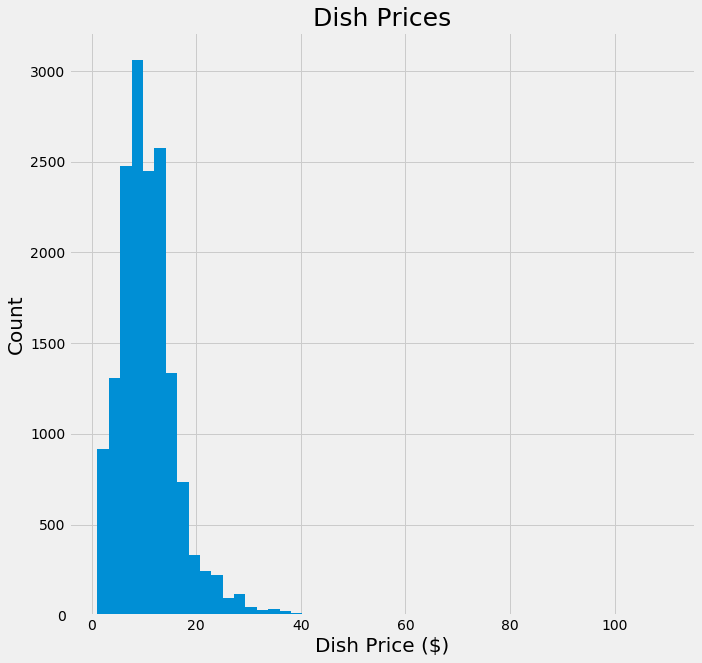

In [29]:
plt.rc('figure', figsize=(10.0, 10.0))
plt.style.use('fivethirtyeight')
plt.tight_layout(h_pad = 1.5)
model_df.iloc[:, 0].hist(bins = 50)
plt.xlabel('Dish Price ($)', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Dish Prices', fontsize = 25)
plt.savefig('AllDishPriceHist.png', format = 'png', bbox_inches = "tight")

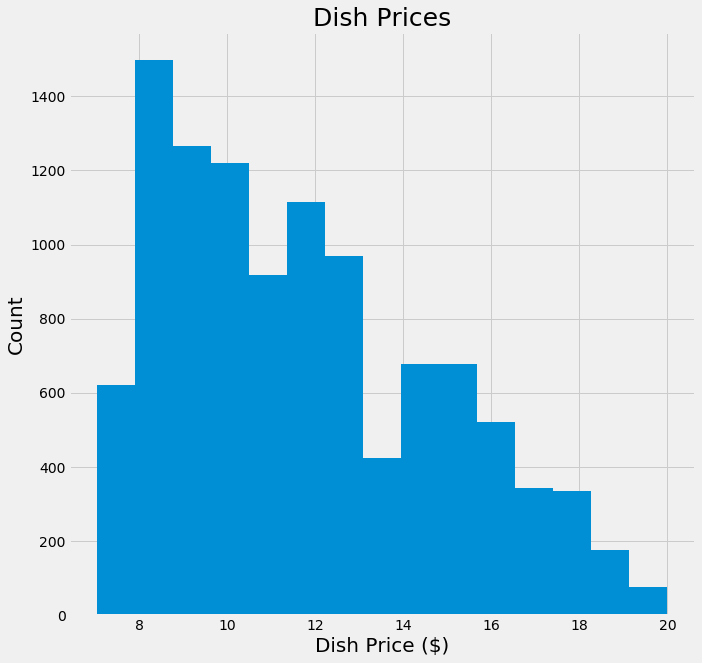

In [30]:
ss_model_df.iloc[:, 0].hist(bins = 15)
plt.xlabel('Dish Price ($)', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Dish Prices', fontsize = 25)
plt.savefig('SSDishPriceHist.png', format = 'png', bbox_inches = "tight")

Histogram of dish prices that have had a boxcox transformation applied

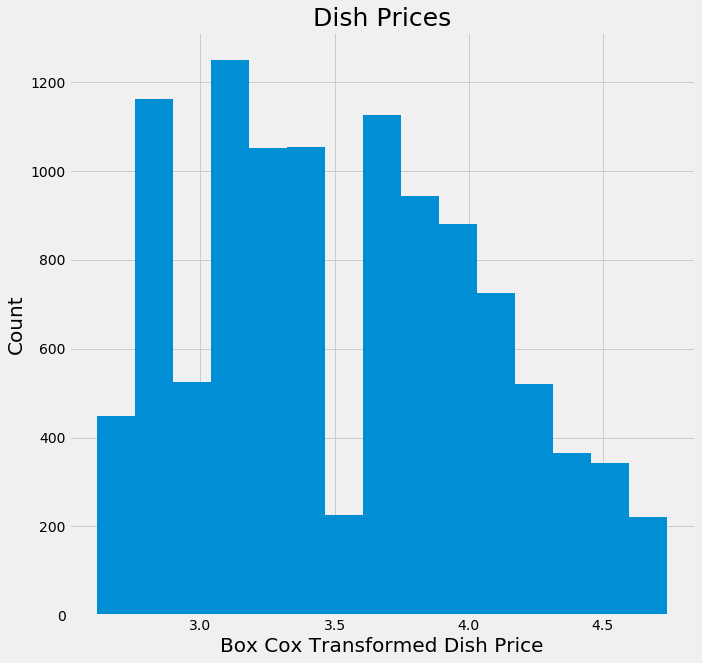

In [31]:
ss_model_df.iloc[:, 0].map(lambda x: stats.boxcox(x, big_L)).hist(bins = 15)
plt.xlabel('Box Cox Transformed Dish Price', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Dish Prices', fontsize = 25)
plt.savefig('BCSSDishPriceHist.png', format = 'png', bbox_inches = "tight")

### Cross Validation
Cross validation scores on total data set and subset of data set

In [ ]:
reg_cv_scores(abs_RI, X_train, y_train, 10, big_L, True)

In [ ]:
reg_cv_scores(abs_RI, ss_X_train, ss_y_train, 10, big_L, True)

In [ ]:
df_cv(abs_RI, ss_X_train, ss_y_train, 10)

### Scoring

MSE, RMSE, and R2 scores for the total dataset where price was log transformed

In [ ]:
log_X_train, log_X_test, log_y_train, log_y_test, log_train_scaler = ttsplit(model_df, dropcol_list, cutdown_list, 10, 30, 10, L = 0, scaling_status = True)
abs_RI.fit(log_X_train, log_y_train)
y_testpredict = abs_RI.predict(log_X_train)        
untr_ypredict = special.inv_boxcox(y_testpredict, 0)
untr_yts = special.inv_boxcox(log_y_train, 0) 
print(f'MSE: {mean_squared_error(untr_ypredict, untr_yts)}')
print(f'RMSE: {np.sqrt(mean_squared_error(untr_ypredict, untr_yts))}')
print(f'R2: {r2_score(untr_yts, untr_ypredict)}')

MSE, RMSE, and R2 scores for the total dataset where price was boxcox transformed. Also using Ridge regression.

In [ ]:
abs_RI.fit(X_train, y_train)
y_testpredict = abs_RI.predict(X_train)        
untr_ypredict = special.inv_boxcox(y_testpredict, big_L)
untr_yts = special.inv_boxcox(y_train, big_L) 
print(f'MSE: {mean_squared_error(untr_ypredict, untr_yts)}')
print(f'RMSE: {np.sqrt(mean_squared_error(untr_ypredict, untr_yts))}')
print(f'R2: {r2_score(untr_yts, untr_ypredict)}')

MSE, RMSE, and R2 scores for the subset dataset where price was boxcox transformed. Also using Ridge regression.

In [ ]:
abs_RI.fit(ss_X_train, ss_y_train)
y_testpredict = abs_RI.predict(ss_X_train)        
untr_ypredict = special.inv_boxcox(y_testpredict, big_L)
untr_yts = special.inv_boxcox(ss_y_train, big_L) 
print(f'MSE: {mean_squared_error(untr_ypredict, untr_yts)}')
print(f'RMSE: {np.sqrt(mean_squared_error(untr_ypredict, untr_yts))}')
print(f'R2: {r2_score(untr_yts, untr_ypredict)}')

MSE, RMSE, and R2 scores on the test set

In [ ]:
abs_RI.fit(ss_X_train, ss_y_train)
y_testpredict = abs_RI.predict(ss_X_test)        
untr_ypredict = special.inv_boxcox(y_testpredict, big_L)
untr_yts = special.inv_boxcox(ss_y_test, big_L) 
print(f'MSE: {mean_squared_error(untr_ypredict, untr_yts)}')
print(f'RMSE: {np.sqrt(mean_squared_error(untr_ypredict, untr_yts))}')
print(f'R2: {r2_score(untr_yts, untr_ypredict)}')

In [ ]:
# Twenty most important coefficients for this model
max_coeffs = sorted([i for i in zip(abs_RI.coef_, ss_X_train.columns)], key= lambda x: abs(x[0]))[-20:]
max_coeffs

### Random Forest
Random Forest regressor appears to do much better for training data. Not that much better for test data. Is overfitting and would need to get more data.

In [ ]:
RF = ensemble.RandomForestRegressor(n_estimators= 20, max_depth = 50)
reg_cv_scores(RF, ss_X_train, ss_y_train, 10, True, big_L)

Random Forest MSE on training set data

In [ ]:
RF.fit(ss_X_train, ss_y_train)
y_testpredict = RF.predict(ss_X_train)        
untr_ypredict = special.inv_boxcox(y_testpredict, big_L)
untr_yts = special.inv_boxcox(ss_y_train, big_L) 
mean_squared_error(untr_ypredict, untr_yts)

Random Forest MSE on test set data

In [ ]:
RF.fit(ss_X_train, ss_y_train)
y_testpredict = RF.predict(ss_X_test)        
untr_ypredict = special.inv_boxcox(y_testpredict, big_L)
untr_yts = special.inv_boxcox(ss_y_test, big_L) 
mean_squared_error(untr_ypredict, untr_yts)

### Residual Plots

In [ ]:
# Residual Plot for all Data
plt.rc('figure', figsize=(10.0, 10.0))
plt.style.use('fivethirtyeight')
abs_RI = Ridge(6.2, random_state = 42)
abs_RI.fit(X_train, y_train)
y_predict = abs_RI.predict(X_train)
total_residual = special.inv_boxcox(y_train, big_L) - special.inv_boxcox(y_predict, big_L)
print(mean_squared_error(special.inv_boxcox(y_predict, big_L), special.inv_boxcox(y_train, big_L)))
plt.scatter(special.inv_boxcox(y_predict, big_L), total_residual, alpha=0.25)
plt.xlabel('Predict Dish Price')
plt.ylabel('Residual');
plt.title('Residual Plot');

5.944786095589526


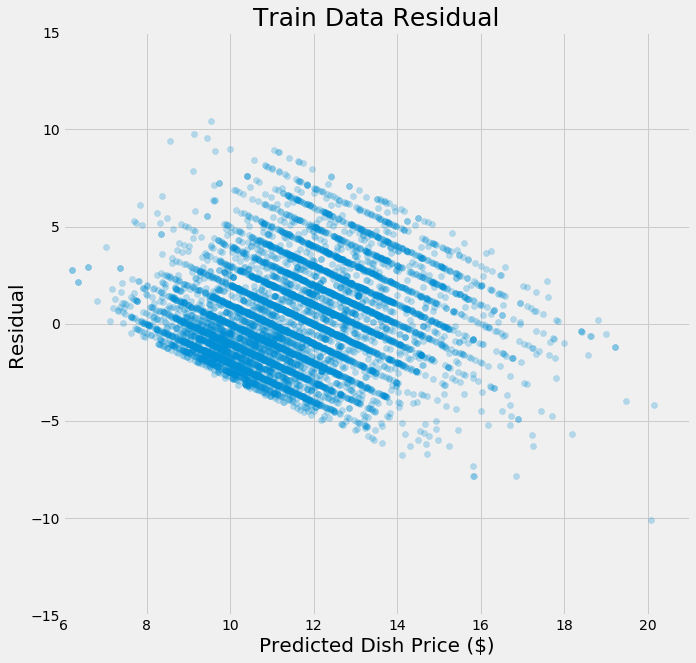

In [32]:
# Residual Plot for subset training data
plt.rc('figure', figsize=(10.0, 10.0))
plt.style.use('fivethirtyeight')
abs_RI.fit(ss_X_train, ss_y_train)
y_predict = abs_RI.predict(ss_X_train)
total_residual = special.inv_boxcox(ss_y_train, big_L) - special.inv_boxcox(y_predict, big_L)
print(mean_squared_error(special.inv_boxcox(y_predict, big_L), special.inv_boxcox(ss_y_train, big_L)))
plt.scatter(special.inv_boxcox(y_predict, big_L), total_residual, alpha=0.25)
plt.xlabel('Predicted Dish Price ($)', fontsize = 20)
plt.ylabel('Residual',  fontsize = 20);
plt.title('Train Data Residual', fontsize = 25);
plt.ylim(-15, 15)
plt.xlim(6, 21)
plt.savefig('Train_Residual_Plot.png', format = 'png', bbox_inches = "tight")

6.907004636179489


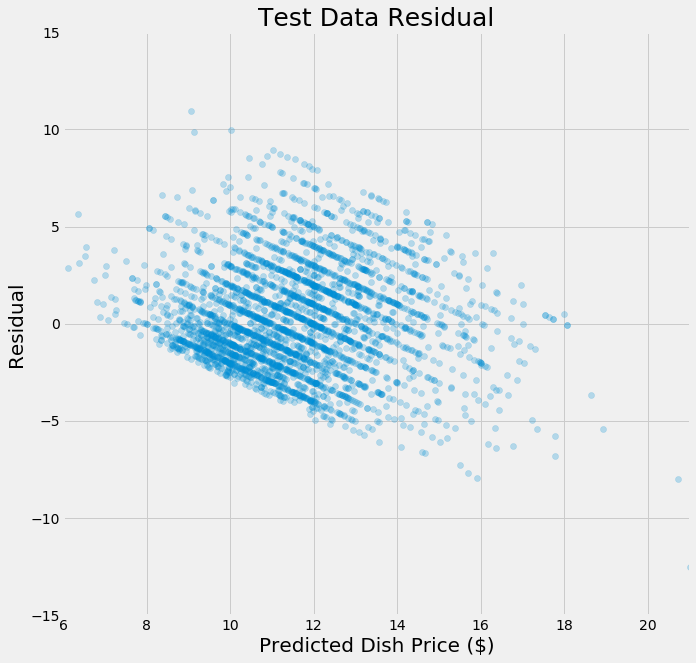

In [33]:
# Residual Plot for Test Data
plt.rc('figure', figsize=(10.0, 10.0))
plt.style.use('fivethirtyeight')
abs_RI.fit(ss_X_train, ss_y_train)
y_predict = abs_RI.predict(ss_X_test)
total_residual = special.inv_boxcox(ss_y_test, big_L) - special.inv_boxcox(y_predict, big_L)
print(mean_squared_error(special.inv_boxcox(y_predict, big_L), special.inv_boxcox(ss_y_test, big_L)))
plt.scatter(special.inv_boxcox(y_predict, big_L), total_residual, alpha=0.25)
plt.xlabel('Predicted Dish Price ($)', fontsize = 20)
plt.ylabel('Residual',  fontsize = 20);
plt.title('Test Data Residual',  fontsize = 25);
plt.ylim(-15, 15)
plt.xlim(6, 21)
plt.savefig('Test_Residual_Plot.png', format = 'png', bbox_inches = "tight")

In [ ]:
# Residual Plot for random forest on test Data
plt.rc('figure', figsize=(10.0, 10.0))
plt.style.use('fivethirtyeight')
RF.fit(ss_X_train, ss_y_train)
y_predict = RF.predict(ss_X_test)
total_residual = special.inv_boxcox(ss_y_test, big_L) - special.inv_boxcox(y_predict, big_L)
plt.scatter(special.inv_boxcox(y_predict, big_L), total_residual, alpha=0.25)
plt.xlabel('Predicted Dish Price ($)', fontsize = 20)
plt.ylabel('Residual',  fontsize = 20);
plt.title('Random Forest Regressor on Test Data', fontsize = 25);
plt.ylim(-15, 15)
plt.xlim(6, 21)
plt.savefig('RF_Residual_Plot.png', format = 'png', bbox_inches = "tight")